# Exercise 5: Practice with MLP Network (3)

##Assignment 4 Author: David Nogales Pérez

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.losses import MeanSquaredError

from sklearn.model_selection import RepeatedKFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.metrics import RootMeanSquaredError
from keras import losses        
from keras import regularizers
import keras
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Generate training data


In [105]:
def y1(k,y,u):
  PI = np.pi
  e = np.e
  u_k = u[k]
  y_k= y[k]
  exp = -(u_k**2)-(y_k**2)
  return 2.5*y_k*np.sin(PI*np.power(e,exp))
def y2(k,y,u):
  u_k=u[k]
  return u_k*(1+u_k**2)

#Generates n samples for the function y(k) described in the problem statement
def generate_data(n=10,seed=12345):
  data = np.zeros(n)
  rng = np.random.default_rng(seed)
  u = rng.uniform(-2,2,n) 
  for i in range(1,n):
    yk= y1(i-1,data,u)+y2(i-1,data,u)
    data[i]=yk
  return np.arange(n),data

n = 500 #training size
X_train,y_train = generate_data(n) 
X_train.shape,y_train.shape

((500,), (500,))

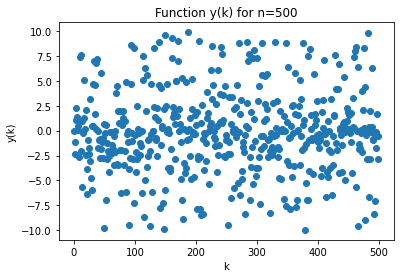

In [106]:
plt.scatter(X_train,y_train)
plt.title(f'Function y(k) for n={n}')
plt.ylabel("y(k)")
plt.xlabel("k")
plt.show()

Plot of 500 samples of the function:

$$y(k)=y_1(k-1)+y_2(k-1)$$
where
  $$y_1(k)=2.5y(k)sin(\pi\epsilon^{-u^2(k)-y^2(k)})$$
  $$y_2(k)=u(k)(1+u^2(k))$$



## Build MLP

In [92]:
#Generates the loss plot for the given history generated by the model
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#Generates a scatter plot of the input data and the prediction of the given model
def plot_predicted(model,X,y):
  plt.scatter(X,y,label="real")
  plt.scatter(X,model.predict(X),label="predicted")
  plt.legend(loc="upper right")
  plt.xlabel("k")
  plt.ylabel("Value")


#Returns a function which generates a 3-hidden layer MLP with the given regularization and activation function   
def buildmodel(act='sigmoid',reg = regularizers.l1_l2()):
    def build():
      model = Sequential()
      model.add(Dense(1, input_dim=1, activation=act, kernel_regularizer=reg))
      model.add(Dense(50, activation=act, kernel_regularizer=reg))
      model.add(Dense(30, activation=act, kernel_regularizer=reg))
      model.add(Dense(15, activation=act, kernel_regularizer=reg))
      model.add(Dense(1,activation = 'linear'))
      model.compile(optimizer="Adam", loss=losses.mean_squared_error,metrics=[RootMeanSquaredError()])
      return model
    return build


Applying cross validation to the MLP

In [99]:
parameters = {"activation":["sigmoid","linear","relu"],
              "regularizer":[("L1",regularizers.l1()),("L2",regularizers.l2()),("L1_L2",regularizers.l1_l2())]
              }

results = {
}
for act in parameters["activation"]:
  results[act]={}
  for reg in parameters["regularizer"]:
    build = buildmodel(act,reg[1])
    estimator= KerasRegressor(build_fn=build, epochs=50, batch_size=25, verbose=0)
    kfold= RepeatedKFold(n_splits=5, n_repeats=5)
    result = cross_val_score(estimator, X_train, y_train, cv=kfold, n_jobs=1)  
    mean = result.mean()
    print(f"Cross validation mean of MSE: {mean}") 
    results[act][reg[0]] = mean

Cross validation mean of MSE: -16.952189750671387
Cross validation mean of MSE: -16.827399063110352
Cross validation mean of MSE: -16.93697811126709
Cross validation mean of MSE: -22.822959213256837
Cross validation mean of MSE: -18.354305610656738
Cross validation mean of MSE: -22.08200454711914
Cross validation mean of MSE: -17.559741706848143
Cross validation mean of MSE: -16.844078407287597
Cross validation mean of MSE: -17.384937133789062


,Regularization,Activation,MSE
0,L2,sigmoid,16.827399
1,L2,relu,16.844078
2,L1_L2,sigmoid,16.936978
3,L1,sigmoid,16.952190
4,L1_L2,relu,17.384937
5,L1,relu,17.559742
6,L2,linear,18.354306
7,L1_L2,linear,22.082005
8,L1,linear,22.822959


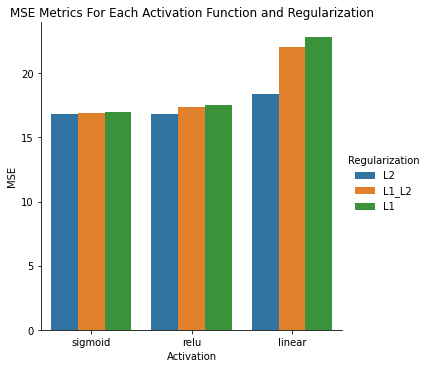

In [102]:
df = pd.DataFrame(results)
df = df.rename_axis('Regularization').reset_index()
df = pd.melt(df,id_vars=["Regularization"],value_vars=['sigmoid',"linear","relu"],var_name='Activation',value_name='MSE').sort_values('MSE',ascending=False).reset_index(drop=True)
df['MSE']=abs(df['MSE'])
ax =  sns.catplot(data=df,x='Activation',y='MSE',hue='Regularization',kind='bar').set(title = 'MSE Metrics For Each Activation Function and Regularization')
df

As seen in the previous graphic the best results are obtained using a Sigmoid activation function with any kind of regularization but L1+L2 regularization will be used from now on.

In [100]:
model = buildmodel()()
history = model.fit(X_train, y_train, epochs=50, batch_size=25, verbose=1)

Epoch 1/50
20/20 [==============================] - 1s 2ms/step - loss: 20.2313 - root_mean_squared_error: 4.0947
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 19.7954 - root_mean_squared_error: 4.0811
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 19.4505 - root_mean_squared_error: 4.0776
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 19.1481 - root_mean_squared_error: 4.0771
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 18.8636 - root_mean_squared_error: 4.0764
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 18.6112 - root_mean_squared_error: 4.0767
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 18.3772 - root_mean_squared_error: 4.0761
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 18.1737 - root_mean_squared_error: 4.0767
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 17.9868 - root_m

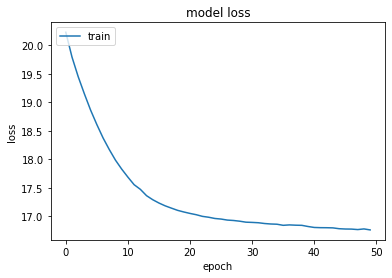

In [103]:
plot_loss(history)

Observing the loss curve we can see that the NN is starting to overfit slightly so no extra epoch are required to fully train the NN.

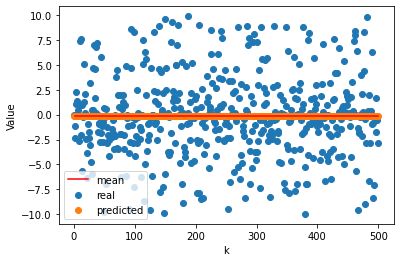

In [124]:
plot_predicted(model,X_train,y_train)   
plt.plot(np.arange(0,n)+1,np.zeros(n)+y_train.mean(),'-r',label="mean")
plt.legend()

In [114]:
y_train.mean()

-0.10853680066900842

In this plot we can see how the MLP predicts a steady line avoiding the noise introduced by the randomness of *u(k)* in the system. Which is really close to the mean of the image values of the function.